## Run DCR Analysis on All Relevant OpSims (DDF Only)
**Author(s):** Weixiang Yu & Gordon Richards
<br>**Last updated:** 03-26-21
<br>**Short description:**
This notebook analyze the `DCRPrecisionMetric` results evaluated on __All__ OpSims in preparation for the SCOC cadence notes on DCR in LSST.

### 0. Software Setup

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import glob
import os, sys

mpl.rc_file('https://raw.githubusercontent.com/ywx649999311/configs/master/viz/yuBasic.rc')
%matplotlib inline

In [2]:
# automatically extract username
your_username = os.getcwd().split('/')[5]
print(f'Your automatically extracted username is: {your_username}.'
        '\nIf it is incorrect, please mannually reset it.')

Your automatically extracted username is: ywx649999311.
If it is incorrect, please mannually reset it.


##### Import the sims_maf modules needed.

In [3]:
# import lsst.sim.maf moduels modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
from lsst.sims.maf.stackers import BaseStacker
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

# add path
sys.path.insert(0, '../src/')
sys.path.insert(0, '../data/run_info//')

# import convenience functions
from opsimUtils import *

### 1. Read data from disk

In [4]:
 # do NOT put your username here, put it in the cell at the top of the notebook.
if your_username == '':
    raise Exception('Please provide your username!  See the top of the notebook.')

resultDbPath = f'/home/idies/workspace/Temporary/{your_username}/scratch/'+\
                'MAFOutput/DCR/AllDDF_v2_n128_033021//ResultDBs/'
metricDataPath = f'/home/idies/workspace/Temporary/{your_username}/scratch'+\
                '/MAFOutput/DCR/AllDDF_v2_n128_033021//MetricData/'

In [5]:
# import metric evaluations
bundleDicts = {}

resultDbsView = getResultsDbs(resultDbPath)
for runName in resultDbsView:
    bundleDicts[runName] = bundleDictFromDisk(resultDbsView[runName], runName, metricDataPath)

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slic

In [6]:
# check keys
dbRuns = list(resultDbsView.keys())
bd_keys = list(bundleDicts[dbRuns[0]].keys())
print(bd_keys)

[(1, 'DCR_24.15_u_XMM-LSS'), (2, 'DCR_22.15_u_XMM-LSS'), (3, 'DCR_24.15_u_COSMOS'), (4, 'DCR_22.15_u_COSMOS'), (5, 'DCR_24_g_ELAISS1'), (6, 'DCR_22_g_ELAISS1'), (7, 'DCR_24_g_XMM-LSS'), (8, 'DCR_22_g_XMM-LSS'), (9, 'DCR_24_g_EDFS'), (10, 'DCR_22_g_EDFS'), (11, 'DCR_24_g_ECDFS'), (12, 'DCR_22_g_ECDFS'), (13, 'DCR_24.15_u_EDFS'), (14, 'DCR_22.15_u_EDFS'), (15, 'DCR_24_g_COSMOS'), (16, 'DCR_22_g_COSMOS'), (17, 'DCR_24.15_u_ELAISS1'), (18, 'DCR_22.15_u_ELAISS1'), (19, 'DCR_24.15_u_ECDFS'), (20, 'DCR_22.15_u_ECDFS')]


#### Keep only result for the relevant OpSims

In [7]:
# read in the list of relevant runs
runs_file = open('../data/run_info/run_list.txt', 'r')
runs_list = runs_file.read().split('\n')
runs_list[:5]

['agnddf_v1.5_10yrs',
 'barebones_nexp2_v1.6_10yrs',
 'barebones_v1.6_10yrs',
 'baseline_2snaps_v1.5_10yrs',
 'baseline_nexp1_v1.6_10yrs']

In [8]:
# select metric results for the relevant opsims
final_bundleDicts = {key:value for (key, value) in bundleDicts.items() if key in runs_list}
final_resultDbs = {key:value for (key, value) in resultDbsView.items() if key in runs_list}

### 2. Make plots
- Get summary statistics
- Make plots at gmag=22 and umag=22.15 using the radar plot
 - Best one from each family 
 - Top 10 and bottom 10

In [9]:
# take Lynne's notes on families
import run_infos as ri

families = ri.FamilyInfo()
fam_db = families.family
family_ls = list(fam_db.keys())

In [10]:
# print all metric names
KeyNames = [key[1] for key in bd_keys]
KeyNames

['DCR_24.15_u_XMM-LSS',
 'DCR_22.15_u_XMM-LSS',
 'DCR_24.15_u_COSMOS',
 'DCR_22.15_u_COSMOS',
 'DCR_24_g_ELAISS1',
 'DCR_22_g_ELAISS1',
 'DCR_24_g_XMM-LSS',
 'DCR_22_g_XMM-LSS',
 'DCR_24_g_EDFS',
 'DCR_22_g_EDFS',
 'DCR_24_g_ECDFS',
 'DCR_22_g_ECDFS',
 'DCR_24.15_u_EDFS',
 'DCR_22.15_u_EDFS',
 'DCR_24_g_COSMOS',
 'DCR_22_g_COSMOS',
 'DCR_24.15_u_ELAISS1',
 'DCR_22.15_u_ELAISS1',
 'DCR_24.15_u_ECDFS',
 'DCR_22.15_u_ECDFS']

#### 2.1 Get summary statistics (Median, Mean, etc.)

In [11]:
# get summary names
summaryNames = getSummaryStatNames(final_resultDbs['baseline_v1.5_10yrs'], 
                                   KeyNames[0])[0]['StatNames']

# loop through metric Keys and summaries -> combine into one pandas df
summary_dfs = []
for KeyName in KeyNames:
    for summaryName in summaryNames:
        summary_df = getSummary(
            final_resultDbs, 
            KeyName, 
            summaryName)[['summaryValue', 'runName']].rename(columns={'summaryValue':
                                                            f'{KeyName}_{summaryName}'})
        summary_dfs.append(summary_df.set_index('runName'))

summary_df_all = summary_dfs[0].join(summary_dfs[1:]).reset_index()

In [12]:
# assign family
comp_run = families.family_baseline
summary_df_all['family'] = ''
for familyName in comp_run:
    if familyName is not 'version_baselines':
        non_comp_runs = [run for run in fam_db[familyName] if run is not comp_run[familyName]]
        summary_df_all.loc[summary_df_all.runName.isin(non_comp_runs), 'family'] = familyName

# if not assigned, it must be one of the baselines
summary_df_all.loc[summary_df_all.family == '', 'family'] = 'baseline'

# sort by family
summary_df_all = summary_df_all.sort_values('family').set_index('runName')

#### 2.2 `DCR_22.15_u` 
- Best one from each family (plus all baseline comparision runs)
- Best 10 and worst 10

__!!__ All metric values will be normalized to the result of the `XMM-LSS` field from comparision

In [13]:
from radar_plot import *
from matplotlib.colors import ListedColormap

In [14]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)

    return ListedColormap(color_list, name=cmap_name)

In [15]:
def radar(df, rgrids=[0.7, 1.0, 1.3, 1.6], cmap=None,
          alpha=0.1, legend=True, figsize=(8.5, 5), fill=False,
          bbox_to_anchor=(1.6, 0.5)):
    """
    make a radar plot!
    """
    theta = radar_factory(np.size(df.columns), frame='polygon')
    fig, axes = plt.subplots(figsize=figsize, subplot_kw=dict(projection='radar'))
    axes.set_rgrids(rgrids)

    ix = 0
    my_cmap = discrete_cmap(len(df), cmap)
    for i, row in df.iterrows():
        axes.plot(theta, row.values, 'o-', label=i, color=my_cmap(ix), markersize=4)
        if fill:
            axes.fill(theta, row.values, alpha=alpha)
        ix += 1

    variables = df.columns.values

    axes.set_varlabels(variables)
    if legend:
        axes.legend(bbox_to_anchor=bbox_to_anchor, borderaxespad=0, loc='lower right')
    axes.set_ylim([np.min(rgrids), np.max(rgrids)])

    return fig, axes

In [16]:
# define normalizing run
norm_run = 'baseline_v1.5_10yrs'
norm_metric_u_22_15 = summary_df_all.loc[norm_run, 'DCR_22.15_u_XMM-LSS_Median']
norm_metric_g_22 = summary_df_all.loc[norm_run, 'DCR_22_g_XMM-LSS_Median']

##### 2.2.1 __Best one from each family + All three baseline comparison runs__

In [17]:
# make a separate df only containing medians
u_median_22_15_cols = [col for col in summary_df_all.columns 
                       if '_Median' in col and '_u_' in col and '_22.15_' in col]
u_median_22_15_df = summary_df_all.loc[:, u_median_22_15_cols].join(summary_df_all.family)
u_median_22_15_df = u_median_22_15_df[u_median_22_15_df.columns.sort_values(ascending=True)]

In [18]:
# normalize to XMM-LSS
u_median_22_15_normed = u_median_22_15_df.copy()
u_median_22_15_normed.loc[:, u_median_22_15_cols] = \
norm_metric_u_22_15/u_median_22_15_df.loc[:, u_median_22_15_cols]

# compute sum of normalized metric for ranking
u_median_22_15_normed['accum_metric'] = u_median_22_15_normed.sum(axis=1)
u_median_22_15_normed.sort_values('accum_metric', inplace=True, ascending=False)

In [19]:
## sort by family and sum of normalized metric
# take the best from each family (higher is better), but keep all three baselines
best_u_family_no_baseline = u_median_22_15_normed[
    u_median_22_15_normed.family != 'baseline'
].sort_values(['family', 'accum_metric'], 
              ascending=[True, False]).drop_duplicates(subset='family')

best_u_family = pd.concat([u_median_22_15_normed[u_median_22_15_normed.family == 'baseline'], 
                           best_u_family_no_baseline], 
                           axis=0).sort_values('accum_metric', ascending=False)

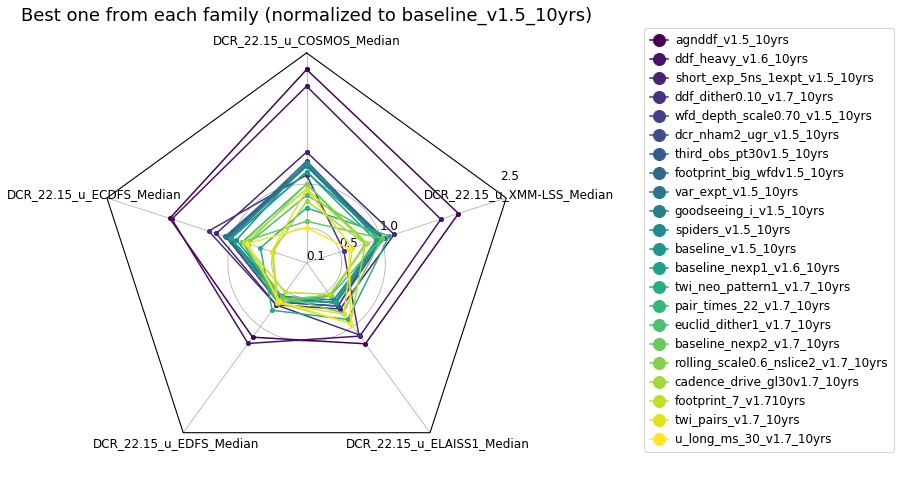

In [20]:
radar(best_u_family.drop(['family', 'accum_metric'], axis=1), bbox_to_anchor=(1.9, 0.05),
     figsize=(15, 7), rgrids=[0.1, 0.5, 1, 2.5], cmap='viridis', alpha=0.8)
_ = plt.title('Best one from each family (normalized to baseline_v1.5_10yrs)', fontsize=18)
plt.tight_layout()

##### 2.2.2 __Best 10 & Worst 10 of All__

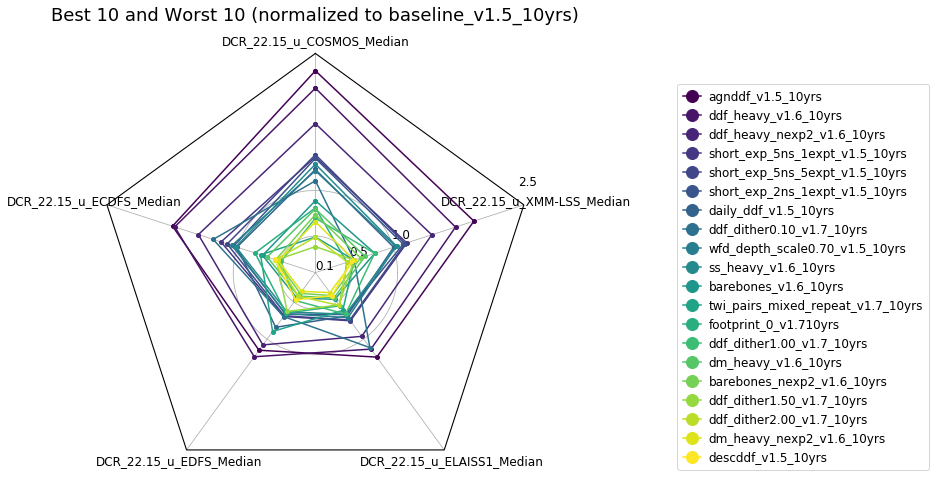

In [21]:
best_worst_u = pd.concat([u_median_22_15_normed.iloc[:10], u_median_22_15_normed.iloc[-10:]])
radar(best_worst_u.drop(['family', 'accum_metric'], axis=1), bbox_to_anchor=(1.9, 0.05),
     figsize=(15, 7), rgrids=[0.1, 0.5, 1, 2.5], cmap='viridis', alpha=0.8)
_ = plt.title('Best 10 and Worst 10 (normalized to baseline_v1.5_10yrs)', fontsize=18)
plt.tight_layout()

#### 2.3 `DCR_22_g`
- Best one from each family (plus all baseline comparision runs)
- Best 10 and worst 10

##### 2.3.1 __Best one from each family + All three baseline comparison runs__

In [22]:
# make a separate df only containing medians
g_median_22_cols = [col for col in summary_df_all.columns 
                    if '_Median' in col and '_g_' in col and '_22_' in col]
g_median_22_df = summary_df_all.loc[:, g_median_22_cols].join(summary_df_all.family)
g_median_22_df = g_median_22_df[g_median_22_df.columns.sort_values(ascending=True)]

In [23]:
# normalize to XMM-LSS
g_median_22_normed = g_median_22_df.copy()
g_median_22_normed.loc[:, g_median_22_cols] = \
norm_metric_g_22/g_median_22_df.loc[:, g_median_22_cols]

# compute sum of normalized metric for ranking
g_median_22_normed['accum_metric'] = g_median_22_normed.sum(axis=1)
g_median_22_normed.sort_values('accum_metric', inplace=True, ascending=False)

In [24]:
## sort by family and sum of normalized metric
# take the best from each family (higher is better), but keep all three baselines
best_g_family_no_baseline = g_median_22_normed[
    g_median_22_normed.family != 'baseline'
].sort_values(['family', 'accum_metric'], 
              ascending=[True, False]).drop_duplicates(subset='family')

best_g_family = pd.concat([g_median_22_normed[g_median_22_normed.family == 'baseline'], 
                           best_g_family_no_baseline], 
                           axis=0).sort_values('accum_metric', ascending=False)

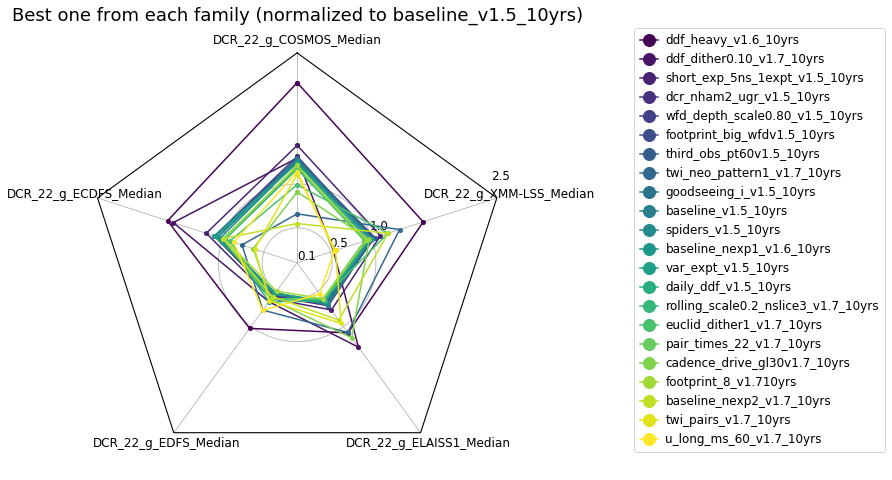

In [25]:
radar(best_g_family.drop(['family', 'accum_metric'], axis=1), bbox_to_anchor=(1.9, 0.05),
     figsize=(15, 7), rgrids=[0.1, 0.5, 1, 2.5], cmap='viridis', alpha=0.8)
_ = plt.title('Best one from each family (normalized to baseline_v1.5_10yrs)', fontsize=18)
plt.tight_layout()

##### 2.3.2 __Best 10 & Worst 10 of All__

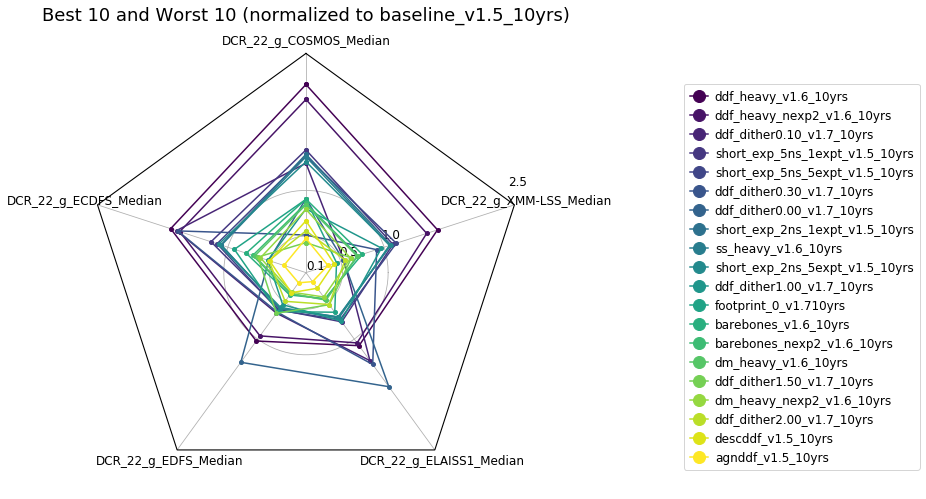

In [26]:
best_worst_g = pd.concat([g_median_22_normed.iloc[:10], g_median_22_normed.iloc[-10:]])
radar(best_worst_g.drop(['family', 'accum_metric'], axis=1), bbox_to_anchor=(1.9, 0.05),
     figsize=(15, 7), rgrids=[0.1, 0.5, 1, 2.5], cmap='viridis', alpha=0.8)
_ = plt.title('Best 10 and Worst 10 (normalized to baseline_v1.5_10yrs)', fontsize=18)
plt.tight_layout()

### 3. Cadence Notes Figures

#### 3.1 `DCR_22_g`

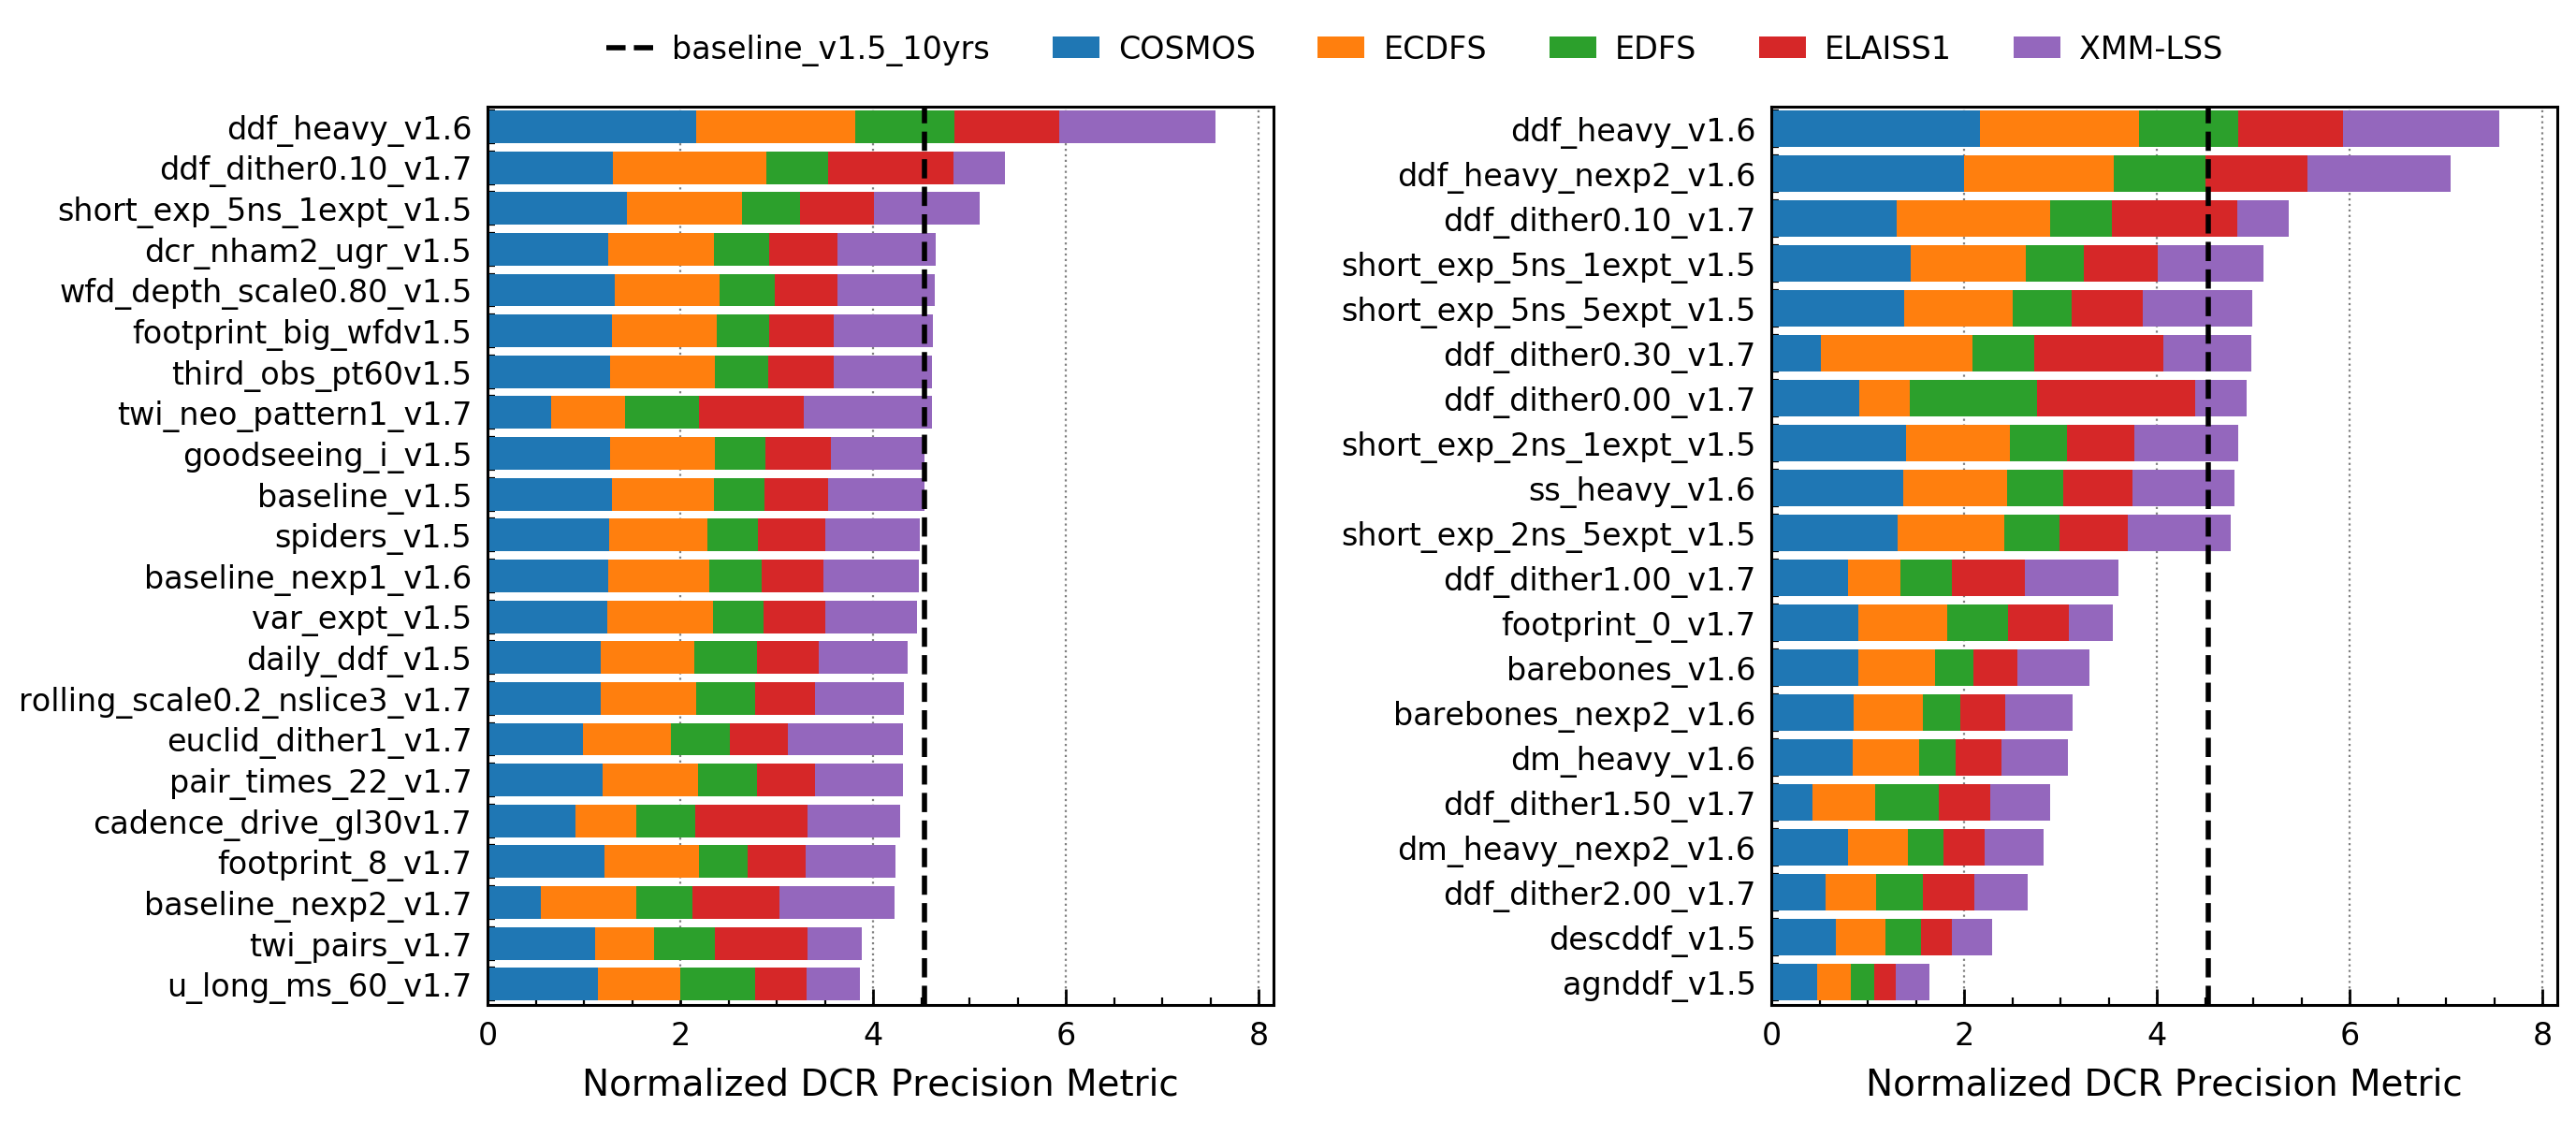

In [27]:
# start plot
fig = plt.figure(figsize=(14, 6), dpi=200)
ax1 = fig.add_axes([0.19, 0.125, 0.3, 0.8])
ax2 = fig.add_axes([0.68, 0.125, 0.3, 0.8])
    
## left: best one from every family
## --------------------------------
stack_bar_g_family = best_g_family.sort_values('accum_metric').drop(['family', 'accum_metric'], axis=1)
left = len(stack_bar_g_family) * [0]
run_labels = [run[:run.find('v1.')+4] for run in stack_bar_g_family.index]
for idx, name in enumerate(stack_bar_g_family.columns):
    ax1.barh(run_labels, stack_bar_g_family[name], left = left, color=mpl.cm.tab10.colors[idx])
    left = left + stack_bar_g_family[name] 

# labels
labels = [col.split('_')[3] for col in stack_bar_g_family.columns]
ax1.set_xlabel('Normalized DCR Precision Metric')

# adjust limits and draw grid lines
ax1.set_ylim(-0.5, ax1.get_yticks()[-1] + 0.5)
ax1.set_axisbelow(True)
ax1.xaxis.grid(color='gray', linestyle=':')

# mark the baseline comparison run metric
baseline_normed_g_sum = g_median_22_normed.loc[norm_run, 'accum_metric']
ax1_ylim = ax1.get_ylim()
ax1.vlines(baseline_normed_g_sum, ymin=ax1_ylim[0], ymax=ax1_ylim[1], 
           linestyle='dashed', linewidth=2, label=norm_run)

# add legend
ax1.legend([norm_run]+labels, bbox_to_anchor=([0.1, 1, 0, 0]), ncol=6, 
           frameon=False, fontsize=12)


## right: best 10 and worst 10
## ---------------------------
stack_bar_g_best_worst = best_worst_g.sort_values('accum_metric').drop(['family', 'accum_metric'], axis=1)
left = len(stack_bar_g_best_worst) * [0]
run_labels = [run[:run.find('v1.')+4] for run in stack_bar_g_best_worst.index]
for idx, name in enumerate(stack_bar_g_best_worst.columns):
    ax2.barh(run_labels, stack_bar_g_best_worst[name], left = left, color=mpl.cm.tab10.colors[idx])
    left = left + stack_bar_g_best_worst[name] 

# title, legend, labels
ax2.set_xlabel('Normalized DCR Precision Metric')

# adjust limits and draw grid lines
ax2.set_ylim(-0.5, ax2.get_yticks()[-1] + 0.5)
ax2.set_axisbelow(True)
ax2.xaxis.grid(color='gray', linestyle=':')

# mark the baseline comparison run metric
ax2_ylim = ax2.get_ylim()
ax2.vlines(baseline_normed_g_sum, ymin=ax2_ylim[0], ymax=ax2_ylim[1], 
           linestyle='dashed', linewidth=2, label=norm_run)

# plt.savefig('dcr_cad_note_ddf_g.pdf')

#### 3.2 `DCR_22.15_u`

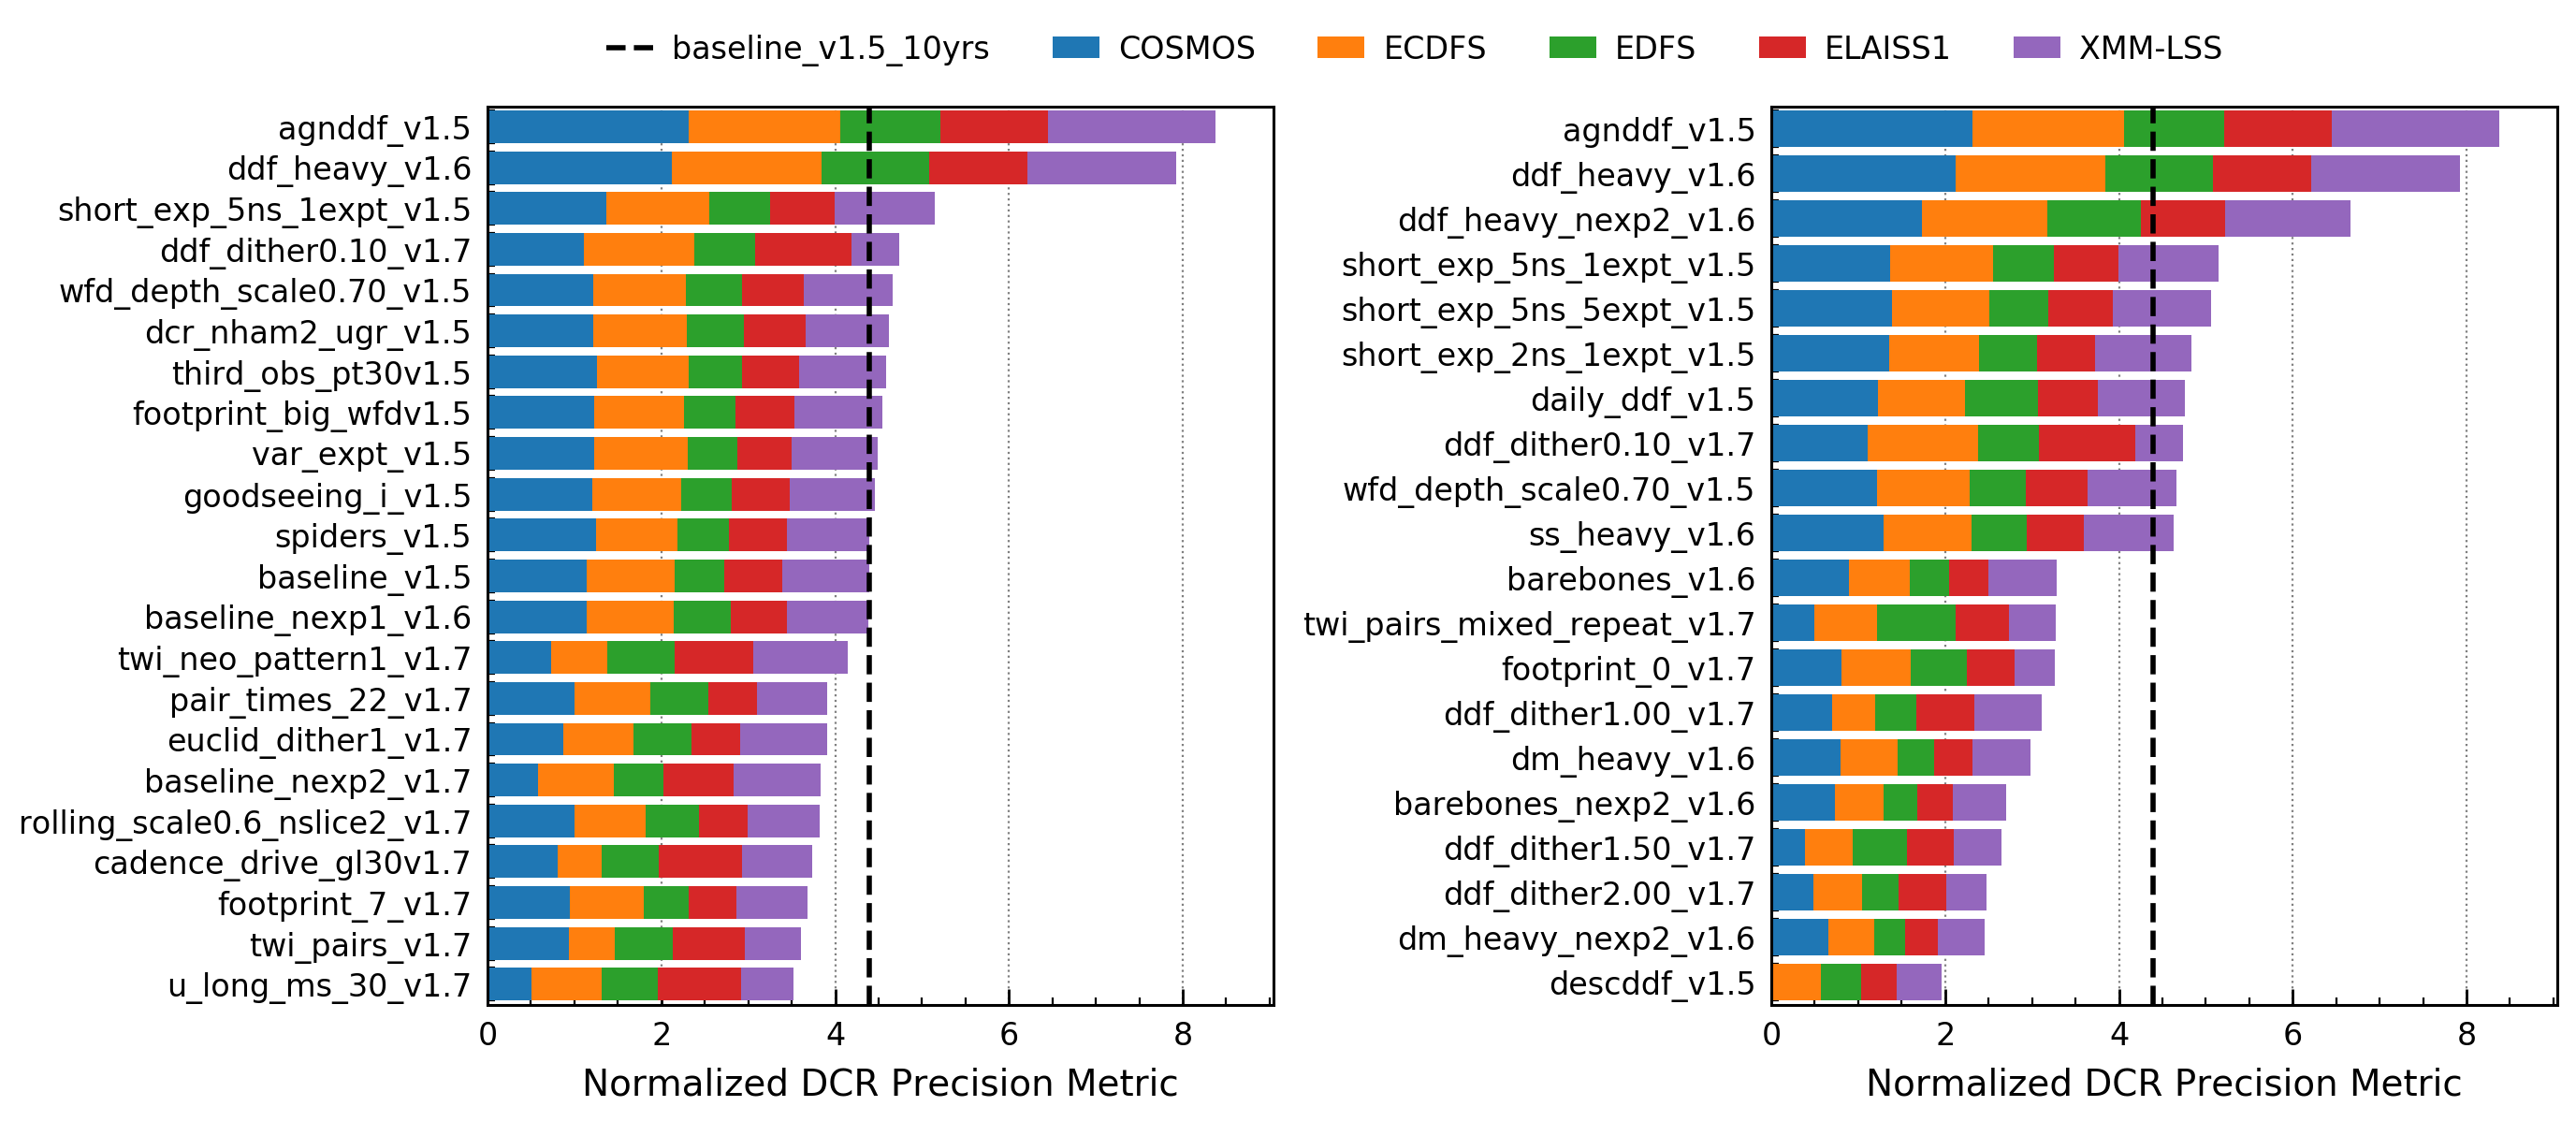

In [28]:
# start plot
fig = plt.figure(figsize=(14, 6), dpi=200)
ax1 = fig.add_axes([0.19, 0.125, 0.3, 0.8])
ax2 = fig.add_axes([0.68, 0.125, 0.3, 0.8])
    
## left: best one from every family
stack_bar_u_family = best_u_family.sort_values('accum_metric').drop(['family', 'accum_metric'], axis=1)
left = len(stack_bar_u_family) * [0]
run_labels = [run[:run.find('v1.')+4] for run in stack_bar_u_family.index]
for idx, name in enumerate(stack_bar_u_family.columns):
    ax1.barh(run_labels, stack_bar_u_family[name], left = left, color=mpl.cm.tab10.colors[idx])
    left = left + stack_bar_u_family[name] 

# labels
labels = [col.split('_')[3] for col in stack_bar_u_family.columns]
ax1.set_xlabel('Normalized DCR Precision Metric')

# adjust limits and draw grid lines
ax1.set_ylim(-0.5, ax1.get_yticks()[-1] + 0.5)
ax1.set_axisbelow(True)
ax1.xaxis.grid(color='gray', linestyle=':')

# mark the baseline comparison run metric
baseline_normed_u_sum = u_median_22_15_normed.loc[norm_run, 'accum_metric']
ax1_ylim = ax1.get_ylim()
ax1.vlines(baseline_normed_u_sum, ymin=ax1_ylim[0], ymax=ax1_ylim[1], 
           linestyle='dashed', linewidth=2, label=norm_run)

# add legend
ax1.legend([norm_run]+labels, bbox_to_anchor=([0.1, 1, 0, 0]), ncol=6, 
           frameon=False, fontsize=12)

## right: best 10 and worst 10
stack_bar_u_best_worst = best_worst_u.sort_values('accum_metric').drop(['family', 'accum_metric'], axis=1)
left = len(stack_bar_u_best_worst) * [0]
run_labels = [run[:run.find('v1.')+4] for run in stack_bar_u_best_worst.index]

# replace nan with zero (descddf)
stack_bar_u_best_worst = stack_bar_u_best_worst.fillna(0)

for idx, name in enumerate(stack_bar_u_best_worst.columns):
    ax2.barh(run_labels, stack_bar_u_best_worst[name], left = left, color=mpl.cm.tab10.colors[idx])
    left = left + stack_bar_u_best_worst[name] 

# title, legend, labels
ax2.set_xlabel('Normalized DCR Precision Metric')

# adjust limits and draw grid lines
ax2.set_ylim(-0.5, ax2.get_yticks()[-1] + 0.5)
ax2.set_axisbelow(True)
ax2.xaxis.grid(color='gray', linestyle=':')

# mark the baseline comparison run metric
ax2_ylim = ax2.get_ylim()
ax2.vlines(baseline_normed_u_sum, ymin=ax2_ylim[0], ymax=ax2_ylim[1], 
           linestyle='dashed', linewidth=2, label=norm_run)

# plt.savefig('dcr_cad_note_ddf_u.pdf')

### 3.3 Show family for the opsims plotted above

#### 3.3.1 u-band: Best one from each family

In [29]:
best_u_family['family']

runName
agnddf_v1.5_10yrs                                       ddf
ddf_heavy_v1.6_10yrs                   potential_schedulers
short_exp_5ns_1expt_v1.5_10yrs                     shortexp
ddf_dither0.10_v1.7_10yrs                       ddf_dithers
wfd_depth_scale0.70_v1.5_10yrs                    wfd_depth
dcr_nham2_ugr_v1.5_10yrs                                dcr
third_obs_pt30v1.5_10yrs                         intranight
footprint_big_wfdv1.5_10yrs                       footprint
var_expt_v1.5_10yrs                              visit_time
goodseeing_i_v1.5_10yrs                         good_seeing
spiders_v1.5_10yrs                                  spiders
baseline_v1.5_10yrs                                baseline
baseline_nexp1_v1.6_10yrs                          baseline
twi_neo_pattern1_v1.7_10yrs                    twilight_neo
pair_times_22_v1.7_10yrs                         pair_times
euclid_dither1_v1.7_10yrs                    euclid_dithers
baseline_nexp2_v1.7_10yrs       

#### 3.3.2 u-band: Best 10 & Worst 10

In [30]:
best_worst_u['family']

runName
agnddf_v1.5_10yrs                                     ddf
ddf_heavy_v1.6_10yrs                 potential_schedulers
ddf_heavy_nexp2_v1.6_10yrs           potential_schedulers
short_exp_5ns_1expt_v1.5_10yrs                   shortexp
short_exp_5ns_5expt_v1.5_10yrs                   shortexp
short_exp_2ns_1expt_v1.5_10yrs                   shortexp
daily_ddf_v1.5_10yrs                                  ddf
ddf_dither0.10_v1.7_10yrs                     ddf_dithers
wfd_depth_scale0.70_v1.5_10yrs                  wfd_depth
ss_heavy_v1.6_10yrs                  potential_schedulers
barebones_v1.6_10yrs                 potential_schedulers
twi_pairs_mixed_repeat_v1.7_10yrs          twilight_pairs
footprint_0_v1.710yrs                      footprint_tune
ddf_dither1.00_v1.7_10yrs                     ddf_dithers
dm_heavy_v1.6_10yrs                  potential_schedulers
barebones_nexp2_v1.6_10yrs           potential_schedulers
ddf_dither1.50_v1.7_10yrs                     ddf_dithers
ddf_di

#### 3.3.2 g-band: Best one from each family

In [31]:
best_g_family['family']

runName
ddf_heavy_v1.6_10yrs                   potential_schedulers
ddf_dither0.10_v1.7_10yrs                       ddf_dithers
short_exp_5ns_1expt_v1.5_10yrs                     shortexp
dcr_nham2_ugr_v1.5_10yrs                                dcr
wfd_depth_scale0.80_v1.5_10yrs                    wfd_depth
footprint_big_wfdv1.5_10yrs                       footprint
third_obs_pt60v1.5_10yrs                         intranight
twi_neo_pattern1_v1.7_10yrs                    twilight_neo
goodseeing_i_v1.5_10yrs                         good_seeing
baseline_v1.5_10yrs                                baseline
spiders_v1.5_10yrs                                  spiders
baseline_nexp1_v1.6_10yrs                          baseline
var_expt_v1.5_10yrs                              visit_time
daily_ddf_v1.5_10yrs                                    ddf
rolling_scale0.2_nslice3_v1.7_10yrs                 rolling
euclid_dither1_v1.7_10yrs                    euclid_dithers
pair_times_22_v1.7_10yrs        

#### 3.3.4 g-band: Best 10 & Worst 10

In [32]:
best_worst_g['family']

runName
ddf_heavy_v1.6_10yrs              potential_schedulers
ddf_heavy_nexp2_v1.6_10yrs        potential_schedulers
ddf_dither0.10_v1.7_10yrs                  ddf_dithers
short_exp_5ns_1expt_v1.5_10yrs                shortexp
short_exp_5ns_5expt_v1.5_10yrs                shortexp
ddf_dither0.30_v1.7_10yrs                  ddf_dithers
ddf_dither0.00_v1.7_10yrs                  ddf_dithers
short_exp_2ns_1expt_v1.5_10yrs                shortexp
ss_heavy_v1.6_10yrs               potential_schedulers
short_exp_2ns_5expt_v1.5_10yrs                shortexp
ddf_dither1.00_v1.7_10yrs                  ddf_dithers
footprint_0_v1.710yrs                   footprint_tune
barebones_v1.6_10yrs              potential_schedulers
barebones_nexp2_v1.6_10yrs        potential_schedulers
dm_heavy_v1.6_10yrs               potential_schedulers
ddf_dither1.50_v1.7_10yrs                  ddf_dithers
dm_heavy_nexp2_v1.6_10yrs         potential_schedulers
ddf_dither2.00_v1.7_10yrs                  ddf_dithers
de

## -------------- Stop --------------------

In [33]:
# # figure and axis
# fig, ax = plt.subplots(1, figsize=(8, 8), dpi=120)

# # plot bars
# stack_bar_df = best_u_family.sort_values('accum_metric').drop(['family', 'accum_metric'], axis=1)
# left = len(stack_bar_df) * [0]
# run_labels = [run[:run.find('v1.')+4] for run in stack_bar_df.index]
# for idx, name in enumerate(stack_bar_df.columns):
#     plt.barh(run_labels, stack_bar_df[name], left = left, color=mpl.cm.tab10.colors[idx])
#     left = left + stack_bar_df[name] 

# # title, legend, labels
# # plt.title('Video Game Sales By Platform and Region\n', loc='left')
# labels = [col.split('_')[3] for col in stack_bar_df.columns]
# ax.legend(labels, bbox_to_anchor=([0.05, 1, 0, 0]), ncol=5, frameon=False, fontsize=10)
# plt.xlabel('Normalized DCR Precision Metric')

# # remove spines
# # ax.spines['right'].set_visible(False)
# # ax.spines['left'].set_visible(False)
# # ax.spines['top'].set_visible(False)
# # ax.spines['bottom'].set_visible(False)

# # adjust limits and draw grid lines
# plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
# ax.set_axisbelow(True)
# ax.xaxis.grid(color='gray', linestyle=':')

# # mark the baseline comparison run metric
# baseline_normed_sum = u_median_22_15_normed.loc['baseline_v1.5_10yrs', 'accum_metric']
# ylim = ax.get_ylim()
# plt.vlines(baseline_normed_sum, ymin=ylim[0], ymax=ylim[1], 
#            linestyle='dashed', linewidth=2, label='baseline_v1.5_10yrs')